## import

In [1]:
import os
import json
import re
import nltk
from tqdm import tqdm
import pandas as pd
import numpy as np
from konlpy.tag import Okt
import scipy.stats as stats
from scipy.sparse import hstack, csr_matrix
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import joblib

## 데이터 가져오기

In [2]:
# 데이터 폴더 경로 설정
cb_folder = "../datas//낚시성 기사 탐지 데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Auto_SO"  # 클릭베이트 데이터
nm_folder = "../datas/낚시성 기사 탐지 데이터/Training/02.라벨링데이터/TL_Part1_NonClickbait_Auto_SO"  # 정상 데이터

# 데이터 로드 함수
def load_data_from_folder(folder, label):
    data = []
    file_list = [f for f in os.listdir(folder) if f.endswith('.json')]
    for file_name in tqdm(file_list, desc=f"Loading data from {folder}"):
        file_path = os.path.join(folder, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = json.load(file)
            title = content["sourceDataInfo"]["newsTitle"]
            text = content["sourceDataInfo"]["newsContent"]
            data.append({"newsTitle": title, "newsContent": text, "clickbaitClass": label})
    return data

# 클릭베이트 및 정상 데이터 로드
cb_data = load_data_from_folder(cb_folder, label=0)
nm_data = load_data_from_folder(nm_folder, label=1)

# 데이터프레임 생성
df_news = pd.DataFrame(cb_data + nm_data)
print(f"Loaded {len(df_news)} records.")

Loading data from ../datas//낚시성 기사 탐지 데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Auto_SO: 100%|██████████| 28956/28956 [00:05<00:00, 4900.17it/s]
Loading data from ../datas/낚시성 기사 탐지 데이터/Training/02.라벨링데이터/TL_Part1_NonClickbait_Auto_SO: 100%|██████████| 28135/28135 [00:05<00:00, 4893.71it/s]

Loaded 57091 records.


## 전처리 및 Features

In [3]:
def preprocess_text(text):
    # 백슬래시 제거
    text = text.replace("\\", "")
    # 중복된 공백 제거
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_news["newsTitle"] = df_news["newsTitle"].apply(preprocess_text)
df_news["newsContent"] = df_news["newsContent"].apply(preprocess_text)

In [4]:
# 한국어 불용어 로드
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read().splitlines()

stopwords_path = "stopwords-ko.txt"
korean_stopwords = load_stopwords(stopwords_path)

In [5]:
# 텍스트 전처리 함수
def preprocess_text_stop(text, stop_words):
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [6]:
# 제목과 본문 전처리
df_news['cleanedTitle'] = df_news['newsTitle'].apply(lambda x: preprocess_text_stop(x, korean_stopwords))
df_news['cleanedContent'] = df_news['newsContent'].apply(lambda x: preprocess_text_stop(x, korean_stopwords))

df_news["combined_text"] = df_news["newsTitle"] + " " + df_news["newsContent"]

In [7]:
# 텍스트 길이 추가
df_news['titleLength'] = df_news['cleanedTitle'].apply(len)
df_news['contentLength'] = df_news['cleanedContent'].apply(len)

In [8]:
# title_content_ratio 추가
df_news['title_content_ratio'] = df_news['titleLength'] / (df_news['contentLength'] + 1e-6)

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
tfidf_matrix_title = tfidf_vectorizer.fit_transform(df_news['newsTitle'])
tfidf_matrix_content = tfidf_vectorizer.transform(df_news['newsContent'])

# 코사인 유도를 사용하는 이유 
# 1. 단어 개수(길이)에 영향을 받지않음
# 2. 고차원 벡터에서도 유용함
# 3. 희소 행렬에서 효과적
cosine_similarities = np.array([
    np.dot(tfidf_matrix_title[i].toarray(), tfidf_matrix_content[i].toarray().T)[0, 0]
    for i in range(len(df_news))
])
df_news['tfidf_similarity'] = cosine_similarities

In [10]:
# 어휘 다양성 계산
# 어휘 다양성이 1에 가까울수록 다양한 단어를 사용한 것
def calculate_lexical_diversity(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    words = text.split()  # 단어 단위로 분리
    unique_words = set(words)  # 고유 단어 집합
    lexical_diversity = len(unique_words) / len(words) if len(words) > 0 else 0
    return lexical_diversity

# Title Lexical Diversity
df_news['title_lexical_diversity'] = df_news['newsTitle'].apply(calculate_lexical_diversity)

# Content Lexical Diversity
df_news['content_lexical_diversity'] = df_news['newsContent'].apply(calculate_lexical_diversity)

In [11]:
def special_char_ratio_features(text):

    if not isinstance(text, str) or len(text.strip()) == 0:
        return {'special_char_ratio': 0}

    # 특수문자 비율
    # \w(문자)와 \s(공백)이 ^(아닌) 문자 —> 특수문자
    special_chars = re.findall(r'[^\w\s]', text)  # 특수문자
    special_char_ratio = len(special_chars) / len(text)

    return {
        'special_char_ratio': special_char_ratio
    }

df_news['special_char_ratio'] = df_news['combined_text'].apply(lambda x: special_char_ratio_features(x)['special_char_ratio'])

df_news['specialCharRatio'] = df_news['special_char_ratio']

In [12]:
# 상위 단어와 Clickbait 중첩률 계산
def get_top_words(row, feature_names, top_n=20):
    row_tfidf = row.toarray().flatten()
    top_indices = row_tfidf.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices]

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df_news['newsContent'])
feature_names = vectorizer.get_feature_names_out()

# 상위 단어 추출 및 중첩률 계산
df_news['top_20_words'] = [get_top_words(tfidf_matrix[i], feature_names) for i in range(tfidf_matrix.shape[0])]

# Clickbait 단어 추출
clickbait_articles = df_news[df_news['clickbaitClass'] == 0]
clickbait_matrix = vectorizer.transform(clickbait_articles['newsContent'])
clickbait_word_sums = clickbait_matrix.sum(axis=0).A1
top_50_clickbait_words = [feature_names[i] for i in clickbait_word_sums.argsort()[-50:][::-1]]

# 중첩 비율 계산 함수
def calculate_overlap_percentage(top_words, clickbait_words):
    overlap = len(set(top_words) & set(clickbait_words))
    return (overlap / len(top_words)) * 100 if top_words else 0

df_news['baitTop50Percentage'] = df_news['top_20_words'].apply(lambda x: calculate_overlap_percentage(x, top_50_clickbait_words))

In [13]:
print(df_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57091 entries, 0 to 57090
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   newsTitle                  57091 non-null  object 
 1   newsContent                57091 non-null  object 
 2   clickbaitClass             57091 non-null  int64  
 3   cleanedTitle               57091 non-null  object 
 4   cleanedContent             57091 non-null  object 
 5   combined_text              57091 non-null  object 
 6   titleLength                57091 non-null  int64  
 7   contentLength              57091 non-null  int64  
 8   title_content_ratio        57091 non-null  float64
 9   tfidf_similarity           57091 non-null  float64
 10  title_lexical_diversity    57091 non-null  float64
 11  content_lexical_diversity  57091 non-null  float64
 12  special_char_ratio         57091 non-null  float64
 13  specialCharRatio           57091 non-null  flo

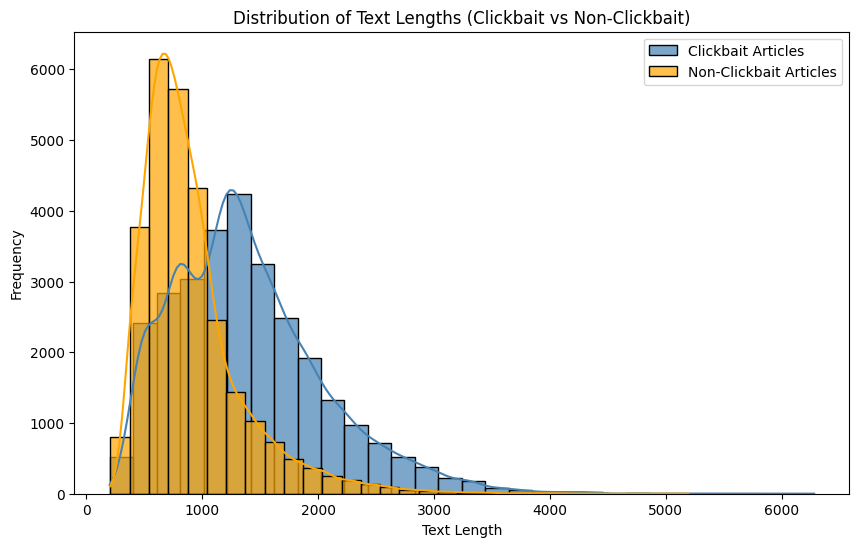

In [14]:
clickbait_articles = df_news[df_news['clickbaitClass'] == 0]['contentLength']
non_clickbait_articles = df_news[df_news['clickbaitClass'] == 1]['contentLength']

# 그래프 설정
plt.figure(figsize=(10, 6))
sns.histplot(clickbait_articles, bins=30, color="steelblue", label="Clickbait Articles", kde=True, alpha=0.7)
sns.histplot(non_clickbait_articles, bins=30, color="orange", label="Non-Clickbait Articles", kde=True, alpha=0.7)

# 제목 및 라벨
plt.title("Distribution of Text Lengths (Clickbait vs Non-Clickbait)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()

# 그래프 출력
plt.show()

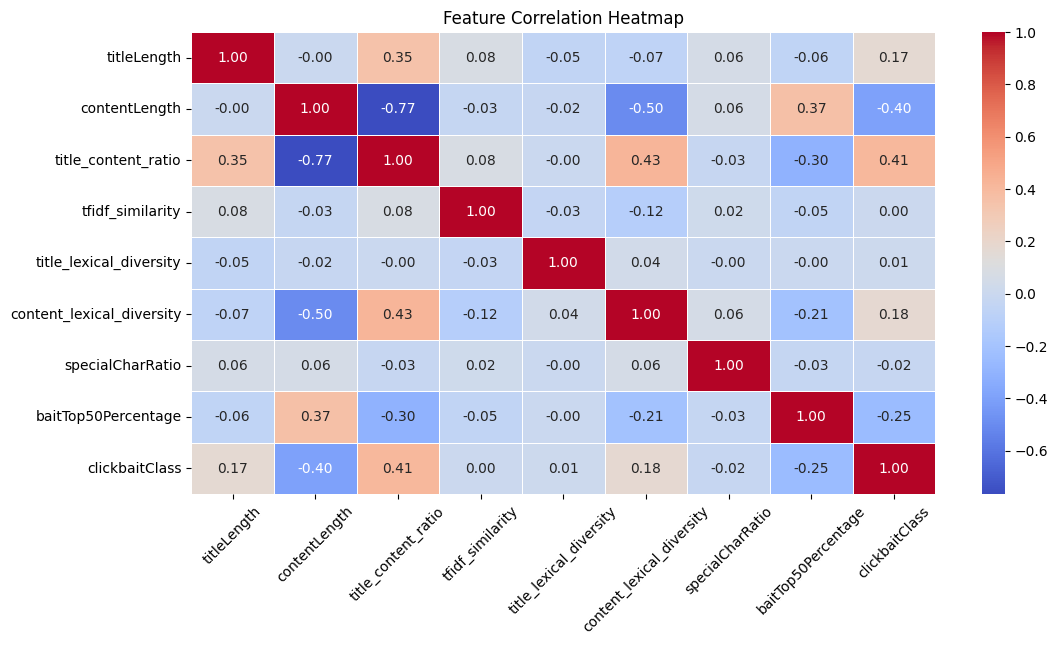

In [14]:
# 상관관계 분석에 사용할 피처 데이터프레임
features_df = df_news[['titleLength', 'contentLength', 'title_content_ratio', 'tfidf_similarity', 'title_lexical_diversity', 'content_lexical_diversity',
                       'specialCharRatio', 'baitTop50Percentage', 'clickbaitClass']]

# 상관관계 행렬 계산
correlation_matrix = features_df.corr()

# Heatmap 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)
plt.title("Feature Correlation Heatmap")
plt.show()


In [20]:
X = df_news[['titleLength', 'contentLength', 'title_content_ratio', 'tfidf_similarity', 'title_lexical_diversity',
             'content_lexical_diversity', 'specialCharRatio', 'baitTop50Percentage']]
y = df_news['clickbaitClass']

In [21]:
# 정규화 (StandardScaler, MinMaxScaler, RobustScaler)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
"""
# 정규화 (StandardScaler, MinMaxScaler, RobustScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
"""

In [20]:
"""
# 정규화 (StandardScaler, MinMaxScaler, RobustScaler)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
"""

In [22]:
# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## RandomForest

In [23]:
# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=200, max_depth = 10, min_samples_leaf = 4, min_samples_split = 2, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 결과 출력
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      5766
           1       0.74      0.73      0.73      5653

    accuracy                           0.74     11419
   macro avg       0.74      0.74      0.74     11419
weighted avg       0.74      0.74      0.74     11419



In [26]:
# 모델 저장
joblib.dump(rf_model, "random_forest_model.pkl")
print("RandomForest 모델이 저장되었습니다.")

RandomForest 모델이 저장되었습니다.


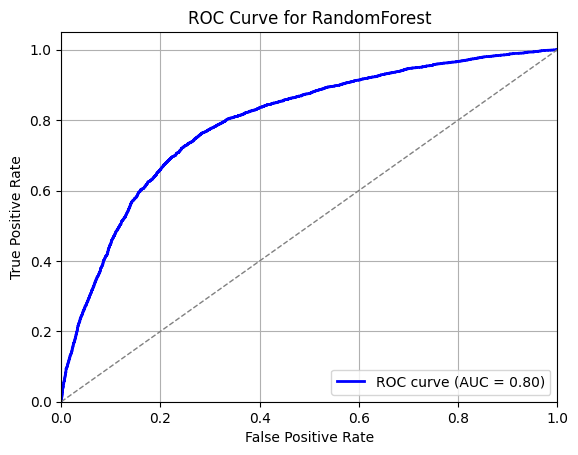

In [24]:
# 예측 확률 계산
y_prob = rf_model.predict_proba(X_test)[:, 1] 

# ROC 커브 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## 실제 기사 데이터 테스트 진행 (RandomForest)

In [27]:
# JSON 파일 로드
with open("model_test_data.json", "r", encoding="utf-8") as file: # test용 실제 기사 json형식 파일
    data = json.load(file)

# 데이터프레임으로 변환
df_test = pd.DataFrame(data)

# 모델 불러오기
rf_model = joblib.load("./random_forest_model.pkl")  # 학습한 모델이 저장된 파일 경로 입력

# 예측 확률 수행
y_pred_proba = rf_model.predict_proba(X_scaled)

# 결과 출력
for title, proba in zip(df_test['title'], y_pred_proba):
    clickbait_proba = proba[1]  # Clickbait 클래스(1)의 확률
    normal_proba = proba[0]     # Normal 클래스(0)의 확률
    
    # 확률이 높은 클래스를 예측 결과로 설정
    label = "Clickbait" if clickbait_proba > normal_proba else "Normal"
    
    # 출력

    print(f"제목: {title}")
    print(f"예측 결과: {label}")
    print(f"Clickbait 확률: {clickbait_proba:.2f}, Normal 확률: {normal_proba:.2f}\n")


제목: 송리단길서 불에 탄 포르쉐...차주는 물 한 잔 붓고 나 몰라라
예측 결과: Normal
Clickbait 확률: 0.15, Normal 확률: 0.85

제목: 가짜뉴스 범벅 '극단적' 유튜브, 왜 똑똑한 사람도 홀릴까
예측 결과: Normal
Clickbait 확률: 0.18, Normal 확률: 0.82



## LogisticRegression

In [28]:
lr_model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=1000) # Sample (수정 필요)
lr_model.fit(X_train, y_train)


y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      5766
           1       0.71      0.75      0.73      5653

    accuracy                           0.73     11419
   macro avg       0.73      0.73      0.73     11419
weighted avg       0.73      0.73      0.73     11419



In [29]:
# 모델 저장
joblib.dump(lr_model, "logistic_regression_model.pkl")
print("LogisticRegression 모델이 저장되었습니다.")

LogisticRegression 모델이 저장되었습니다.


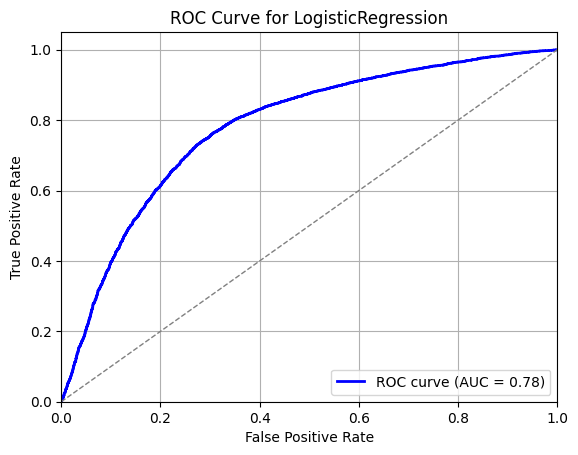

In [30]:
# 예측 확률 계산
y_prob = lr_model.predict_proba(X_test)[:, 1] 

# ROC 커브 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegression')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## 실제 기사 데이터 테스트 진행 (LogisticRegression)

In [32]:
# JSON 파일 로드
with open("./model_test_data.json", "r", encoding="utf-8") as file: # test용 실제 기사 json형식 파일
    data = json.load(file)

# 데이터프레임으로 변환
df_test = pd.DataFrame(data)

# 모델 불러오기
lr_model = joblib.load("./logistic_regression_model.pkl")  # 학습한 모델이 저장된 파일 경로 입력

# 예측 확률 수행
y_pred_proba = lr_model.predict_proba(X_scaled)

# 결과 출력
for title, proba in zip(df_test['title'], y_pred_proba):
    clickbait_proba = proba[1]  # Clickbait 클래스(1)의 확률
    normal_proba = proba[0]     # Normal 클래스(0)의 확률
    
    # 확률이 높은 클래스를 예측 결과로 설정
    label = "Clickbait" if clickbait_proba > normal_proba else "Normal"
    
    # 출력
    print(f"제목: {title}")
    print(f"예측 결과: {label}")
    print(f"Clickbait 확률: {clickbait_proba:.2f}, Normal 확률: {normal_proba:.2f}\n")


제목: 송리단길서 불에 탄 포르쉐...차주는 물 한 잔 붓고 나 몰라라
예측 결과: Normal
Clickbait 확률: 0.08, Normal 확률: 0.92

제목: 가짜뉴스 범벅 '극단적' 유튜브, 왜 똑똑한 사람도 홀릴까
예측 결과: Normal
Clickbait 확률: 0.20, Normal 확률: 0.80

